<a href="https://colab.research.google.com/github/isabellebouchard/ift6135/blob/master/Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO
- check if its better to have smaller filters at the beginning or end of network (see textbook)



# Problem 3

**Instructions**: [Read the rules](https://https://www.kaggle.com/c/ift6135h19/rules) !

The deadline for submissions is February 15th. It is one day before the assignment deadline.

The train and test sets are available in the 'Data' tab. You are responsible for splitting the train set to an actual train and valid sets yourself.

Once you train a model, you should run it on a test set, and generate a CSV file similar to the sample submission ('sample_submission.csv'), that should specify the class for all images of the test set.

Please remember to have ONE MEMBER OF EACH TEAM making all the submissions for the team.

Your submissions will be compared to the ground truth, using the mean classification accuracy metric

The public leaderboard shows your score, calculated with the ground truth of part of the test set. The private leaderboard (only available at the end of the competition) uses the rest of the test set to evaluate your answers. The latter is the score that will be used in grading. This will encourage you to not overfit the test data. Two of your submissions are eligible for the final private leaderboard. You can hand-select the eligible submissions, or it will otherwise default to the best public scoring submissions.

Your score will be taken into account to determine your grade. A score of 0.5 (random guessing or constant classifiers for example) will correspond to a mark of 0%. A score of 0.75 will correspond to a mark of 95% (on this part of the assignment). We will use a concave function on the interval [0.5, 0.75] to determine your mark as a function of the score here. The 5 teams with the highest scores will get a mark of 100% on this part of the assignment.

You can have as much as 4 submissions per UTC day. Please note that this is not an invitation to make dozens of submissions during the competition. The goal of the assignment is for you to apply what you learned in class while having fun.






# CNN Architecture



**Input Image**: 28 x 28

**Convolution 1**: 32 filters, kernel size = 5, stide = 1,  padding = 2

**Max pooling 1**: kernel size = 2

**Convolution 2**: 64 filters, kernel size = 5, stide = 1,  padding = 2

**Max pooling 2**: kernel size = 2

**Convolution 3**: 128 filters, kernel size = 5, stide = 1,  padding = 2

**Max pooling 3**: kernel size = 2

**Convolution 4**: 256 filters, kernel size = 3, stide = 1,  padding = 2

**Max pooling 4**: kernel size = 2

**Fully Connected Layer**: 2 x 2 x 256 

**Ouput:** 10 x 1

**Loss:** softmax + cross-entropy



### Installation Requirements

In [92]:
!pip3 install torch torchvision matplotlib 

### Use GPU 

First, select "GPU" in the Edit Menu -> Notebook Settings -> Hardware Accelerator -> GPU

**torch.cuda**: *This package adds support for CUDA tensor types, that implement the same function as CPU tensors, but they utilize GPUs for computation.*

**torch.cuda.is_available()**: *Returns a bool indicating if CUDA is currently available.*

To go from a tensor type CPU to GPU, add .to("cuda:0")

In [93]:
import torch

use_gpu = torch.cuda.is_available()
print("GPU Available: {}".format(use_gpu))
device = torch.device("cuda:0" if use_gpu else "cpu")

GPU Available: False


### Kaggle Data

**trainset.zip** - zip file with 2 folders ('Cat' and 'Dog') containing the training images

**test.csv** - zip file with 1 folder ('test') that contains the images you should classify - the goal of having the 'test' folder is for you to be able to use 'datasets.ImageFolder'

**sample_submission.csv** - a sample submission file in the correct format - your submission should be **EXACTLY** in this format for the evaluation to work

In [94]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(5),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.Resize([64,64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([64,64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


batch_size = 134

data_dir = './data/cat_dog_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
#image_datasets['train'] = torch.from_numpy(image_datasets['train'])
#image_datasets['val'] = torch.from_numpy(image_datasets['val'])
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('Train_size',dataset_sizes['train'])
print('Val_size',dataset_sizes['val'])
class_names = image_datasets['train'].classes




# # ChunkSampler class is from https://github.com/pytorch/vision/issues/168
# class ChunkSampler(sampler.Sampler):
#     """Samples elements sequentially from some offset. 
#     Arguments:
#         num_samples: # of desired datapoints
#         start: offset where we should start selecting from
#     """
#     def __init__(self, num_samples, start = 0):
#         self.num_samples = num_samples
#         self.start = start

#     def __iter__(self):
#         return iter(range(self.start, self.start + self.num_samples))

#     def __len__(self):
#         return self.num_samples

# train_set = MNIST(root='../data',train=True,transform=transforms.ToTensor(),download=True)
# test_set = MNIST(root='../data',train=False,transform=transforms.ToTensor(),download=True)

# train_set_size = len(train_set)
# NUM_TRAIN = int(0.8 * train_set_size) #cast to int to avoid TypeError: 'float' object cannot be interpreted as an integer
# NUM_VAL = train_set_size - NUM_TRAIN
# NUM_TEST = len(test_set)

# loader_train = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0),shuffle=False)
# loader_val = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN),shuffle=False)
# loader_test = DataLoader(test_set, batch_size=batch_size,shuffle=False)

Train_size 17498
Val_size 2500


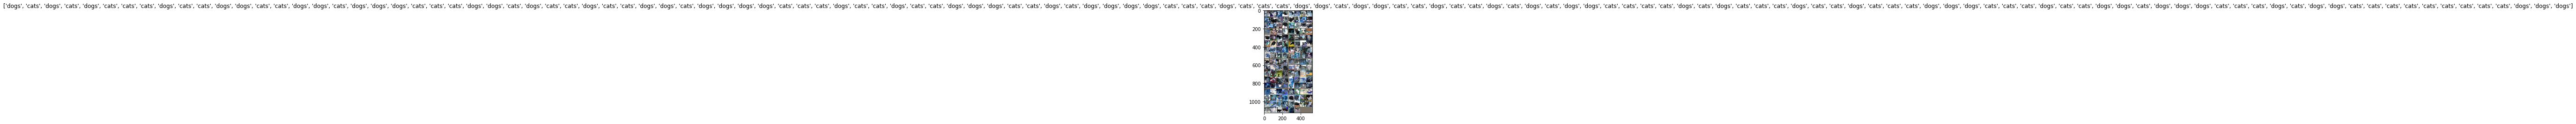

In [95]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### CNN Model

[torch.nn.Module](https://pytorch.org/docs/master/nn.html#torch.nn.Module): Base class for all NN modules. 
Must implement __init__ (defines the layers) and **forward** (returns the output)

[torch.nn.Sequential(*args)](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential): Modules will be added to it in the order they are passed in the constructor

 [torch.nn.Conv2d](https://pytorch.org/docs/master/nn.html#torch.nn.Conv2d)(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
 
[ torch.nn.Sigmoid](https://pytorch.org/docs/master/nn.html#sigmoid)

[torch.nn.MaxPool2d](https://pytorch.org/docs/master/nn.html#torch.nn.MaxPool2d)(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False): Applies a 2D max pooling over an input signal composed of several input planes.

 [torch.nn.Dropout2d](https://pytorch.org/docs/master/nn.html#dropout2d)(p=0.5, inplace=False): *Each channel will be zeroed out independently on every forward call. with probability p using samples from a Bernoulli distribution*

 [torch.nn.Linear](https://pytorch.org/docs/master/nn.html#torch.nn.Linear)(in_features, out_features, bias=True)


In [96]:
import torch.nn as nn
import copy

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=5,padding=2),
        #nn.Sigmoid(),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(32,64,kernel_size=5,padding=2),
        #nn.Sigmoid(),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())

    self.conv3 = nn.Sequential(
        nn.Conv2d(64,128,kernel_size=5,padding=2),
        #nn.Sigmoid(),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.conv4 = nn.Sequential(
        nn.Conv2d(128,256,kernel_size=3,padding=2),
        #nn.Sigmoid(),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.fc = nn.Linear(5*5*256,2)
    
#     self.fc = nn.Sequential(
#         nn.Linear(256*14*14,256*14*14),
#         nn.ReLU(),
#         nn.Linear(256*14*14,500),
#         nn.ReLU(),
#         nn.Linear(500,2)
#     )
        
        
            
        # Linear units
#         self.linear = nn.Sequential(
#             nn.Linear(144 * 14 * 14, 144 * 14 * 14),
#             #nn.BatchNorm1d(144 * 4 * 4),
#             nn.ReLU(),
#             #nn.Dropout(p=0.5),
#             nn.Linear(144 * 14 * 14, 500),
#             #nn.BatchNorm1d(500),
#             nn.ReLU(),
#             #nn.Dropout(p=0.5),
#             nn.Linear(500, 2)
#         )

#     def forward(self, x):
#         #print(x.shape)
#         x = self.conv(x)
#         #print(x.shape)
#         x = x.view(-1, 144*14*14)
#         #print(x.shape)
#         x = self.linear(x)
#         m = nn.Softmax()
#         x = m(x)
#         #print(x.shape)
#         #print(x.shape)
#         return x

  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    #print("print out:",out.size())
    flatten = out.view(out.size(0),-1)
    #print("print flatten:",flatten.size())
    fc = self.fc(flatten)
    return fc

model = CNN()
# put model on GPU
model = model.to(device)

print(model)

print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

# Save the initial weights of model
init_model_wts = copy.deepcopy(model.state_dict())

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (fc): Linear(in_features=6400, out_features=2, bias=True)
)


# Parameters:  56

### Train CNN

#### Loss function

criterion = [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss)(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

#### Minimize loss function using stochastic gradient descent
optimizer = [torch.optim.SGD](https://pytorch.org/docs/master/optim.html#torch.optim.SGD)(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)


In [97]:
learning_rate = 1e-2
num_epochs = 10

#loss function
criterion = nn.CrossEntropyLoss()  

#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model.load_state_dict(init_model_wts)

train_errors = []
eval_errors = []

print("Training begins...")
for epoch in range(num_epochs):
  
  train_error = 0
  train_num = 0
  
  # model in train mode
  model.train()
  
  for i,(digits,labels) in enumerate(dataloaders['train']):
    
    # digits and labels on GPU
#     digits = digits.to(device)
#     labels = labels.to(device)
    
    # zero gradient buffer
    optimizer.zero_grad()
    #print("Digits_Train ",digits)
    #print("Labels ",labels)
    #print("I: ",i)
    #print("Labels",labels)
    # forward pass
    #print("type",type(digits[i]))
    #print("Shape",digits[i].size())
    outputs = model(digits)
    
    #print(outputs)
        
    # loss function
    loss = criterion(outputs,labels)
        
    # backward pass
    loss.backward()
    
    # gradient descent step
    optimizer.step()
    
    # add the loss
    train_error += loss.item()
    train_num += 1
  
  eval_error = 0
  eval_num = 0
  
  # model in eval mode
  print("Eval begins...")
  model.eval()
  
  for i,(digits,labels) in enumerate(dataloaders['val']):
    
    # digits and labels on GPU
#     digits = digits.to(device)
#     labels = labels.to(device)
        
    # forward pass
    #print("Digits_Eval ",digits)

    outputs = model(digits)
    
    # loss function
    loss = criterion(outputs,labels)
        
    # add the loss
    eval_error += loss.item()
    eval_num += 1
    
  
  # save the loss
  train_errors.append(train_error / train_num)
  eval_errors.append(eval_error / eval_num)
  
  #print eval_error after each epoch
  print('\nEpoch {}'.format(epoch + 1))
  print('\tTrain error: {:.4f}'.format(train_error/train_num))  
  print('\tEval error: {:.4f}'.format(eval_error/eval_num))
  

Training begins...


Process Process-367:
Process Process-368:
Process Process-366:
Process Process-362:
Process Process-365:
Process Process-363:
Process Process-361:
Process Process-364:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._arg

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
KeyboardInterrupt
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.6/

KeyboardInterrupt: 

### Evaluate CNN


In [ ]:
# eval_errors = []

# print("Evaluation begins...")

# for epoch in range(num_epochs):
  
#   eval_error = 0
#   eval_num = 0
  
#   # model in eval mode
#   model.eval()
  
#   for digits, labels in loader_val:
    
#     # digits and labels on GPU
#     digits = digits.to(device)
#     labels = labels.to(device)
        
#     # forward pass
#     outputs = model(digits)
    
#     # loss function
#     loss = criterion(outputs,labels)
        
#     # add the loss
#     eval_error += loss.item()
#     eval_num += 1
  
#   # save the loss
#   eval_errors.append(eval_error / eval_num)
  
#   #print eval_error after each epoch
#   print('\nEpoch {}'.format(epoch + 1))
#   print('\tEval error: {:.4f}'.format(eval_error/eval_num))
    

### Plot Train and Valid Errors

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training and validation curve
x = list(range(len(train_errors))) 
plt.plot(x, train_errors,'m',label='Train')
plt.plot(x, eval_errors,'g', label='Validation')

plt.xlabel('Number Epochs')
plt.ylabel('Loss')
plt.legend(loc='best',shadow=True, fancybox=True)
plt.title("Loss")

plt.show()

### Test CNN

In [ ]:
# # model in eval mode
# model.eval()

# correct = 0
# total = 0

# for digits, labels in loader_test:
  
#   # digits and labels on GPU
#   digits = digits.to(device)
#   labels = labels.to(device)
  
#   # forward pass
#   outputs = model(digits)
#   _, predicted = torch.max(outputs.data, 1)
  
#   # save the accuary
  
#   total += labels.size(0)
#   correct += torch.sum(predicted == labels.data)
  
# print('Accuracy on the test set: {:.2f}%'.format(100 * correct / total))
  

# CNN vs. MLP 

## Number of parameters

**CNN with 4 conv layers**

conv1 = 32 filters size 5x5 + 32 biases = 32x5x5+32 = 832

conv2 = 32x64 filters size 5x5 + 64 biases = 32x64x5x5 + 64 = 51,264

conv3 = 64x128 filters size 5x5 + 128 biases = 64x128x5x5 + 128 = 204,928

conv4 = 128x256 filters size 3x3 + 256 biases = 128x256x3x3 + 256 = 295,168

fc = 1x(2x2x256) x 10 + 10 = 10,250

total CNN parameters = 832 + 51,264 + 204,928 + 295,168 + 10,250 = **562,442**



**MLP with 2 hidden layers**

input to h1 = 784 x 512 = 401,408

h1 to h2 = 512 x 1024 = 524,288

h2 to output = 1024 x 10 = 10,240

total MLP parameters = 401,408 + 524,288 + 10,240 = **935,936**

## Discussion

CNN's need significantly less parameters than MLP since they exhibit sparse connectivity and parameter sharing. 

**Sparse connectivity**: direct connections very sparse, but in the deeper layers, units are indirectly connected to all/most of the input image. 

**Parameter sharing**: each member of the kernel is used at every position of the input, meaning the same parameters are used at all input locations. Therefore you learn only one set of parameters. 

Since we are asked to build a CNN with similar number of parameters as the MLP trained in Problem 1, the CNN should outperform the MLP since it needs a significantly smaller number of weights to be able to match an MLP's performance. 

## Performance

If m represents the size of the input image, and n the size of the output image, then MLP requires mxn parameters with O(mxn) runtime. In CNNs, you limit the number of connections of each output to k, this means you only need kxn parameters with O(kxn) runtime. 


# References

List of references we can check out to increase our performance:

*   MNIST Image Class Tensorflow CNN 99.51% Test Accur.: https://www.kaggle.com/raoulma/mnist-image-class-tensorflow-cnn-99-51-test-acc
*   How to Choose CNN Architecture for MNIST: https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
*   99.75% Accur: https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist/notebook

